In [1]:
%load_ext autoreload
%autoreload 2

from readers import *
from datalib import *
from filters import *
import config.config_jump_detection as config
import matplotlib.pyplot as plt
import time as t
%matplotlib notebook

script_starting_time = t.time()

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [15]:
start_time = t.time()
print("Reading demonstration data")

force_ext = []
position_data = []
velocity_data = []

starting_indices = []
ending_indices = []

for i in range(len(config.demos)):
    demo = config.demos[i]
    print(f'Reading demonstration file {demo}')

    force_ext.append(DataSet())
    position_data.append(PositionDataSet())
    velocity_data.append(PositionDataSet())

    # Read data
    franka_reader = FrankaStateReader(demo)
    starting_position = None
    starting_force = None
    ending_position = franka_reader.last_datapoint().value.position
    ending_force = franka_reader.last_datapoint().value.force_external_magnitude
    starting_index = None
    ending_index = None
    
    while not franka_reader.end():
        dp = franka_reader.next_datapoint()
        time = dp.time
        franka_state = dp.value
        
        if starting_position is None:
            starting_position = franka_state.position
            starting_force = franka_state.force_external_magnitude
        elif starting_index is None:
            if franka_state.distance(starting_position) > 0.01 or np.linalg.norm(franka_state.velocity) > 0.01 or abs(franka_state.force_external_magnitude - starting_force) > 0.3:
                starting_index = len(force_ext[i])
        elif ending_index is None:
            if franka_state.distance(ending_position) < 0.01 and np.linalg.norm(franka_state.velocity) < 0.01 and abs(franka_state.force_external_magnitude - ending_force) < 0.3:
                ending_index = len(force_ext[i]) + 1

        force_ext[i].append(DataPoint(time, franka_state.force_external_magnitude))
        position_data[i].append(PositionDataPoint(time, franka_state.position))
        velocity_data[i].append(PositionDataPoint(time, franka_state.velocity))

    if ending_index is None:
        ending_index = -1
    else:
        ending_index = min(len(force_ext[i]) - 1, ending_index+30)
    
    starting_indices.append(starting_index)
    ending_indices.append(ending_index)
        
    # Align time
    force_ext[i].align_time()
    position_data[i].align_time()
    velocity_data[i].align_time()
    
    print(f'Average sampling frequency of {config.demos[i]} is {(len(force_ext[i]) - 1) / (force_ext[i].time[-1] - force_ext[i].time[0])} Hz')

print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Reading demonstration data
Reading demonstration file data/demo3.3.bag
Average sampling frequency of data/demo3.3.bag is 974.0192362364112 Hz
Reading demonstration file data/demo4.3.bag
Average sampling frequency of data/demo4.3.bag is 980.0387088812652 Hz
Reading demonstration file data/demo5.3.bag
Average sampling frequency of data/demo5.3.bag is 969.8827779071169 Hz
Reading demonstration file data/demo6.3.bag
Average sampling frequency of data/demo6.3.bag is 974.4151884729952 Hz
Reading demonstration file data/demo8.3.bag
Average sampling frequency of data/demo8.3.bag is 971.2628380607988 Hz
Reading demonstration file data/demo9.3.bag
Average sampling frequency of data/demo9.3.bag is 967.2646035625883 Hz
--- 83.01654839515686 seconds ---
Done


In [35]:
start_time = t.time()
print("Detecting jumps")

predictions_data = []
bounds_data = []
jump_indices_data = []
impact_indices_data = []

for i in range(len(config.demos)):
    predictions_data.append(DataSet())
    bounds_data.append(DataSet())
    jump_indices_data.append([])
    impact_indices_data.append([])

jump_detector = config.jump_detector.copy()

for i in range(len(config.demos)):
    
    # Detect jumps
    jump_detector.reset()
    starting_index = starting_indices[i]
    ending_index = ending_indices[i]
    for j in range(len(force_ext[i][starting_index:ending_index])):
        jump_detected, info = jump_detector.update(force_ext[i][j+starting_index])
        if jump_detected:
            impact_indices_data[i].append(j+starting_index)
        if info[5]:
            jump_indices_data[i].append(j+starting_index)
        predictions_data[i].append(info[0])
        bounds_data[i].append(info[1])
        
print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Detecting jumps
--- 3.8281381130218506 seconds ---
Done


<IPython.core.display.Javascript object>


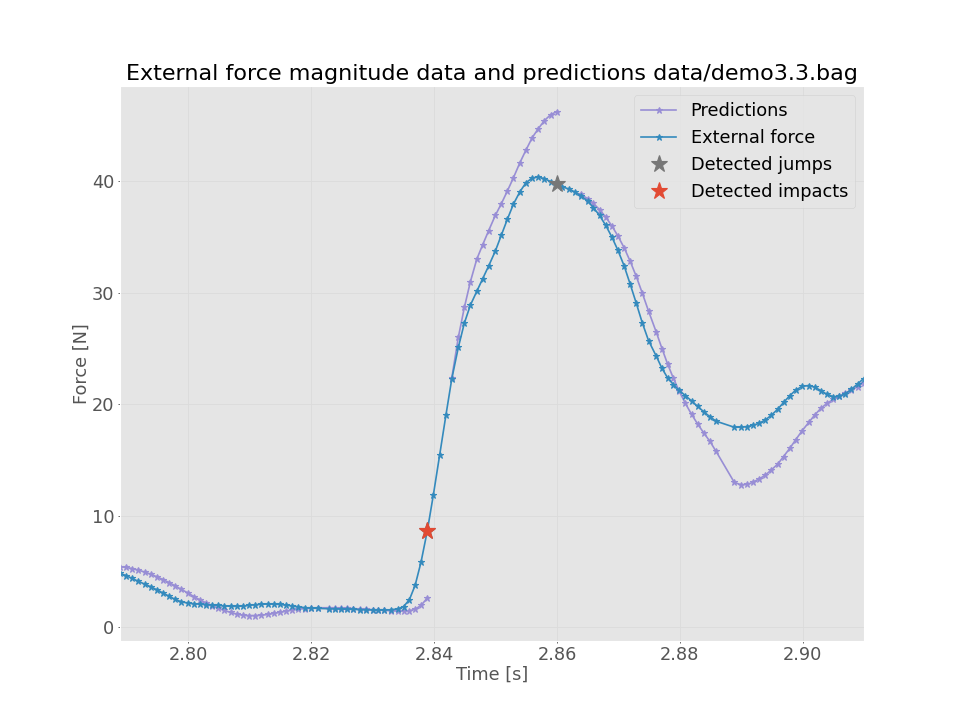

<IPython.core.display.Javascript object>


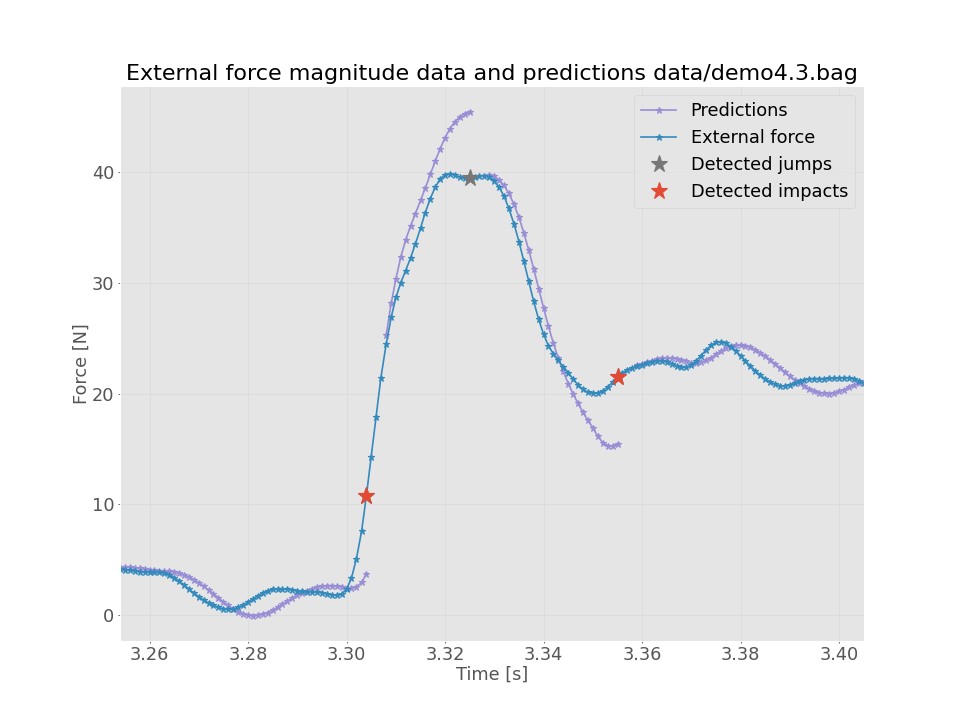

/home/sven/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


<IPython.core.display.Javascript object>


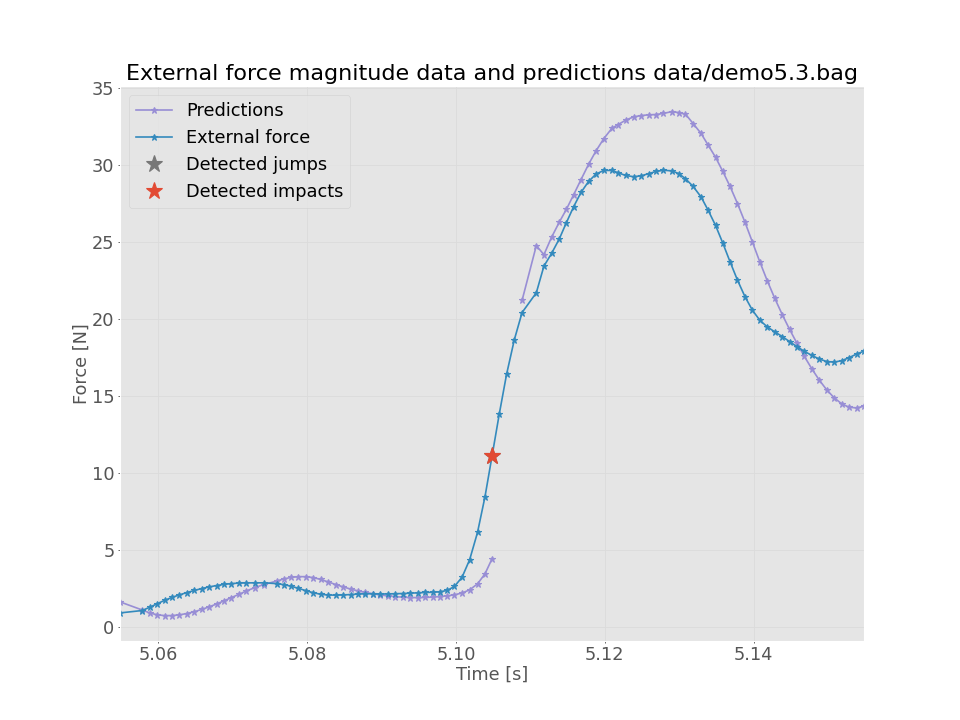

<IPython.core.display.Javascript object>


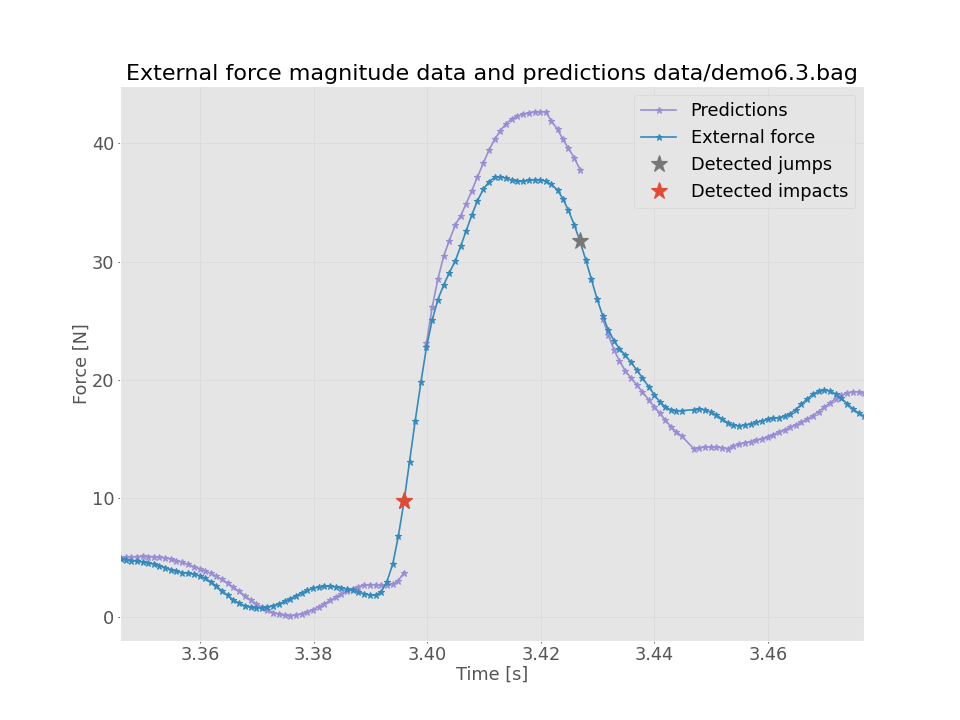

<IPython.core.display.Javascript object>


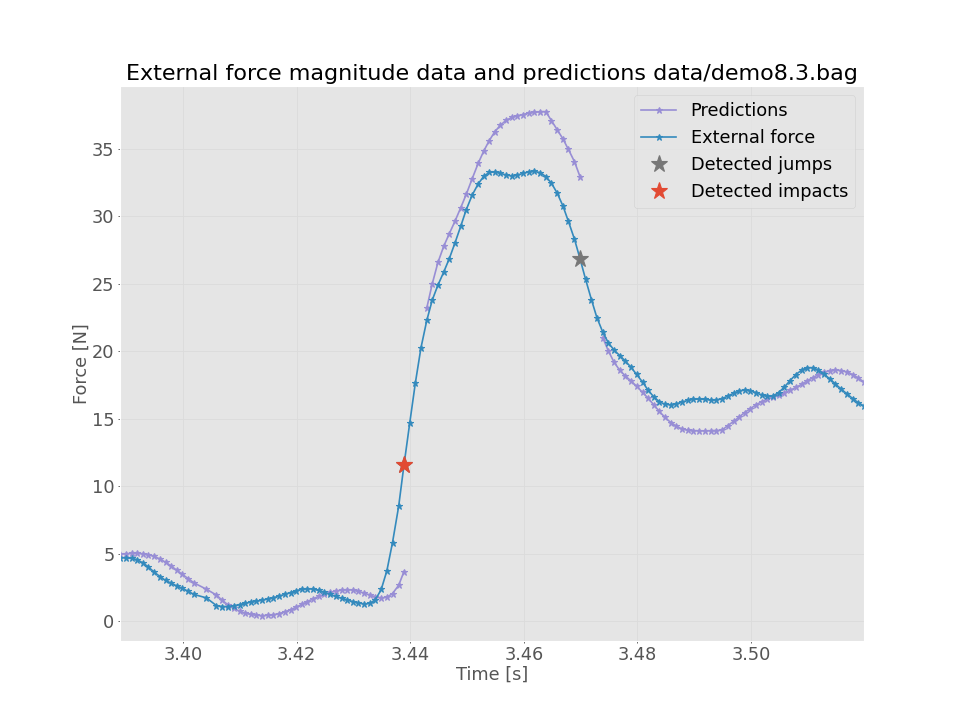

<IPython.core.display.Javascript object>


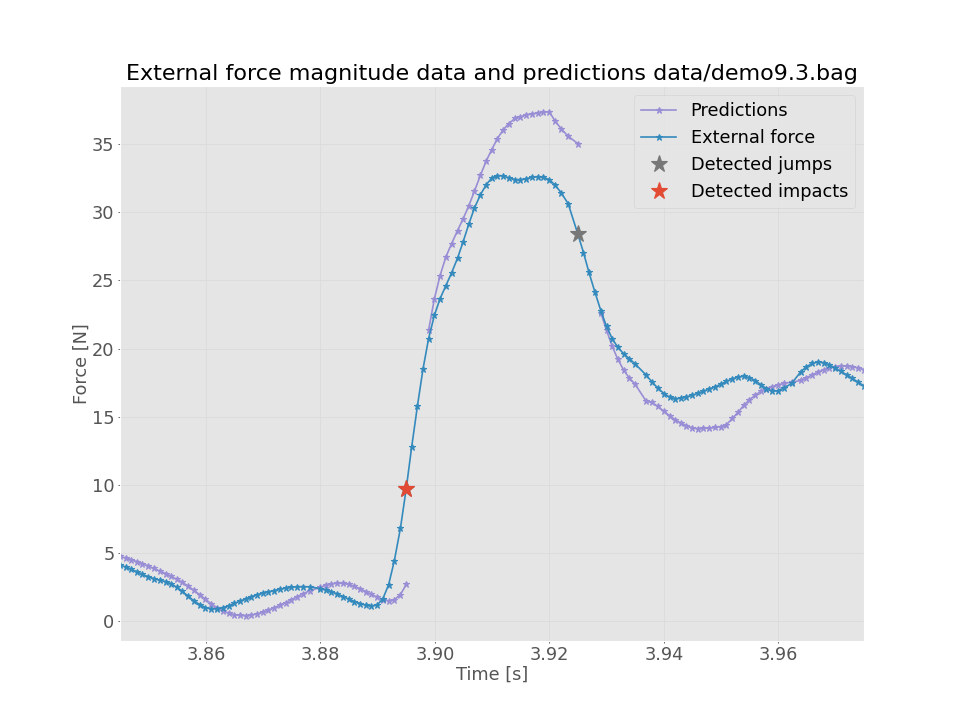

In [36]:
# Plotting external force data

for i in range(len(config.demos)):
    demo = config.demos[i]
    
    ## Plot external force
    fig = plt.figure(figsize=config.figsize, dpi=config.dpi)
    plt.rcParams['xtick.labelsize'] = config.fontsize2
    plt.rcParams['ytick.labelsize'] = config.fontsize2

    # Predictions
    plt.plot(predictions_data[i].time, predictions_data[i].value, 'C2-*', linewidth=config.linewidth, markersize=config.markersize2, label='Predictions')

    # External force data
    plt.plot(force_ext[i].time, force_ext[i].value, 'C1-*', linewidth=config.linewidth, markersize=config.markersize2, label='External force')

    # Jumps and impacts
    force_ext_jumps = force_ext[i][jump_indices_data[i]]
    plt.plot(force_ext_jumps.time, force_ext_jumps.value, 'C3*', linewidth=config.linewidth, markersize=config.markersize1, label='Detected jumps')
    force_ext_impacts = force_ext[i][impact_indices_data[i]]
    plt.plot(force_ext_impacts.time, force_ext_impacts.value, 'C0*', linewidth=config.linewidth, markersize=config.markersize1, label='Detected impacts')
    
    # Adding title and labels
    plt.title('External force magnitude data and predictions ' + demo,fontsize=config.fontsize1)
    plt.xlabel('Time [s]',fontsize=config.fontsize2)
    plt.ylabel('Force [N]',fontsize=config.fontsize2)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),fontsize=config.fontsize2)
    if config.xlim is not None and len(jump_indices_data[i]) > 0:
        x_min = force_ext[i][min(jump_indices_data[i])].time + config.xlim[0]
        x_max = force_ext[i][max(jump_indices_data[i])].time + config.xlim[-1]
        plt.xlim((x_min, x_max))

    title = fig.axes[0].get_title() + demo.split('/')[-1].split('\\')[-1]
    if config.save_figs:
        plt.savefig(config.save_figs_location + '/figures/' + title + '.png')

    if config.pickle_figs:
        pickle.dump(fig,open(config.save_figs_location + '/pickles/' + title + '.pickle','wb'))

    if not config.show_figs:
        plt.close()

if config.show_figs:
    plt.show()

<IPython.core.display.Javascript object>


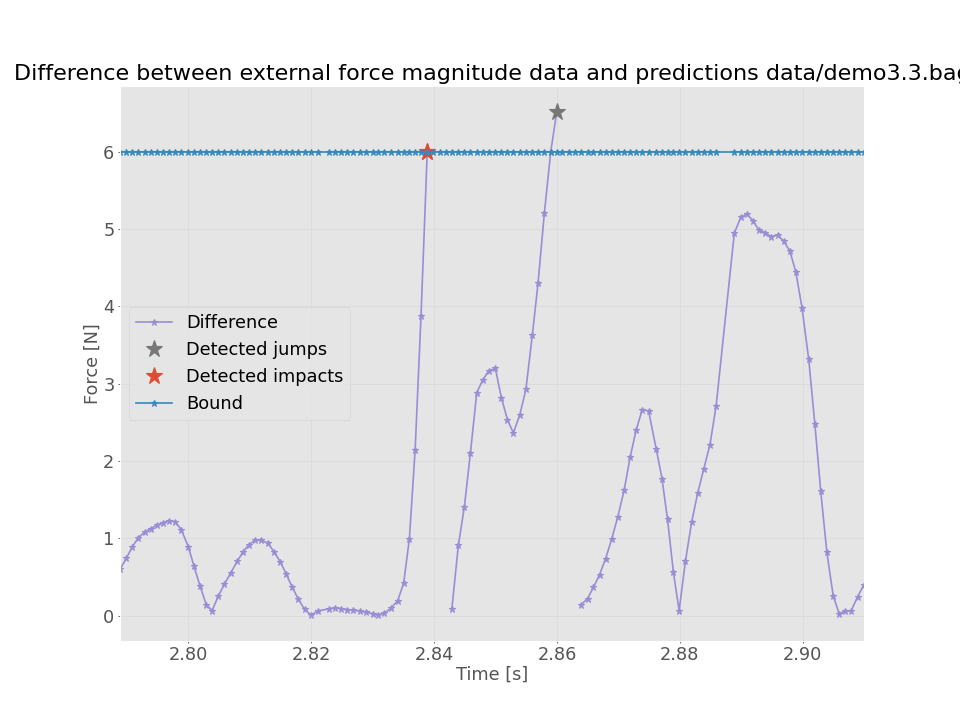

<IPython.core.display.Javascript object>


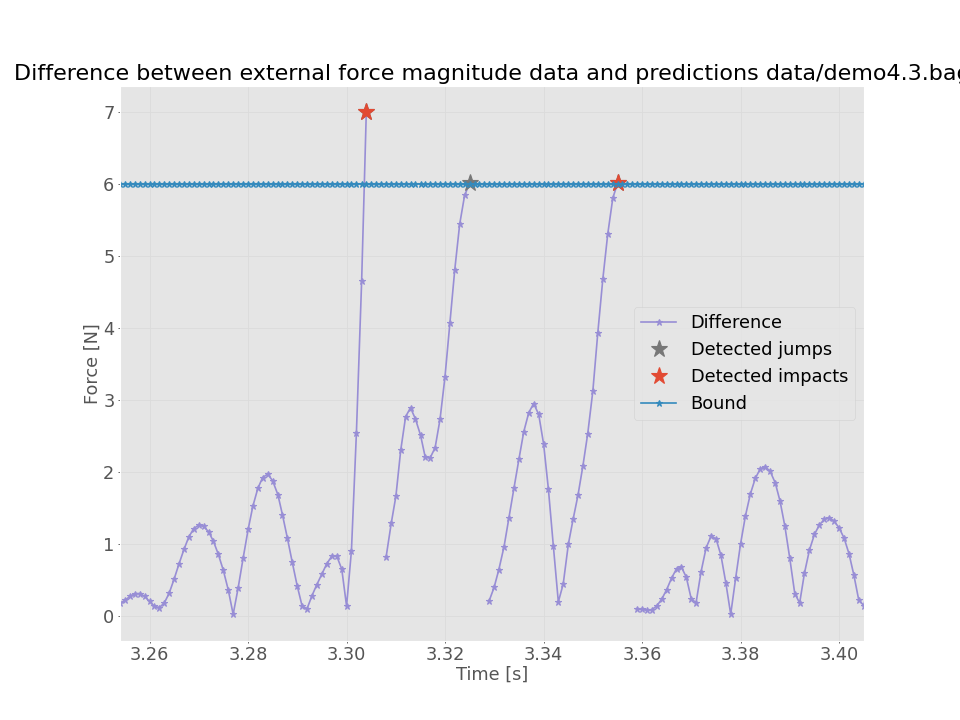

/home/sven/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


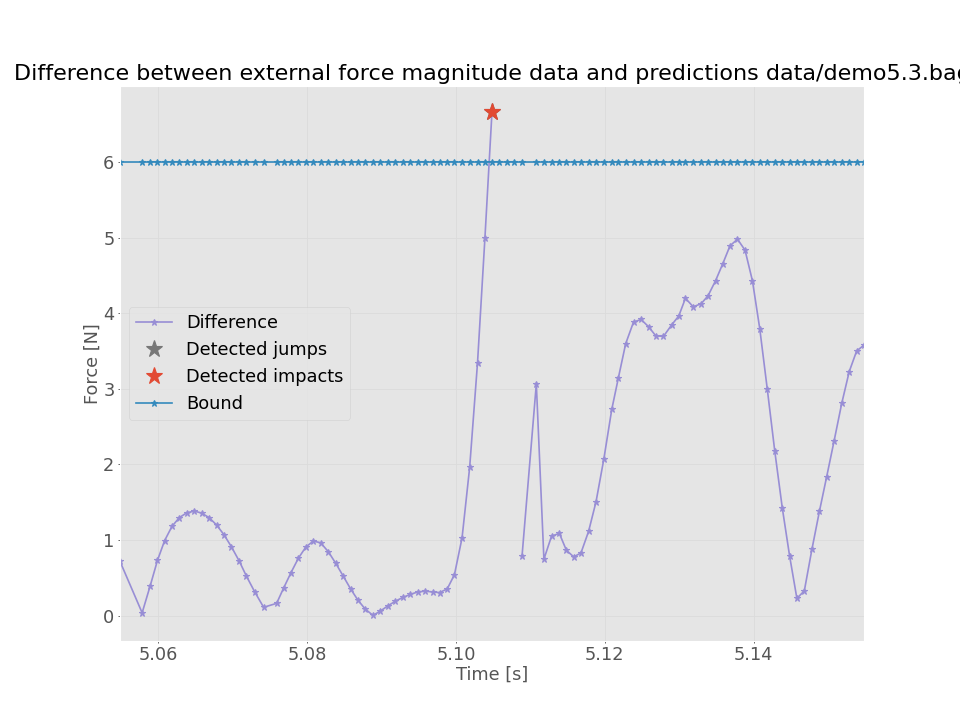

<IPython.core.display.Javascript object>


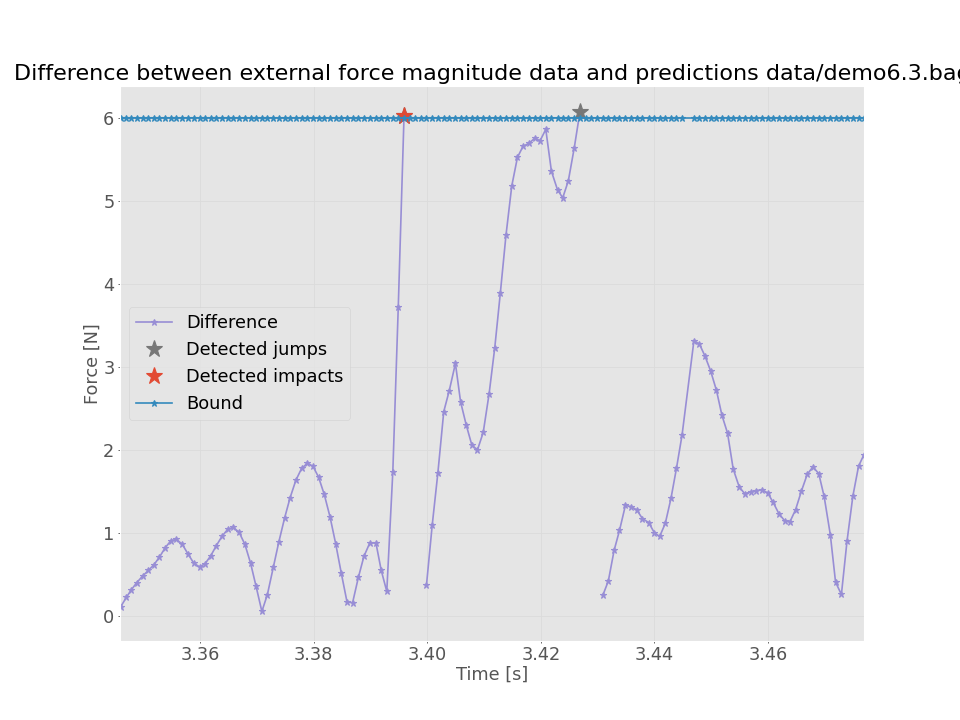

<IPython.core.display.Javascript object>


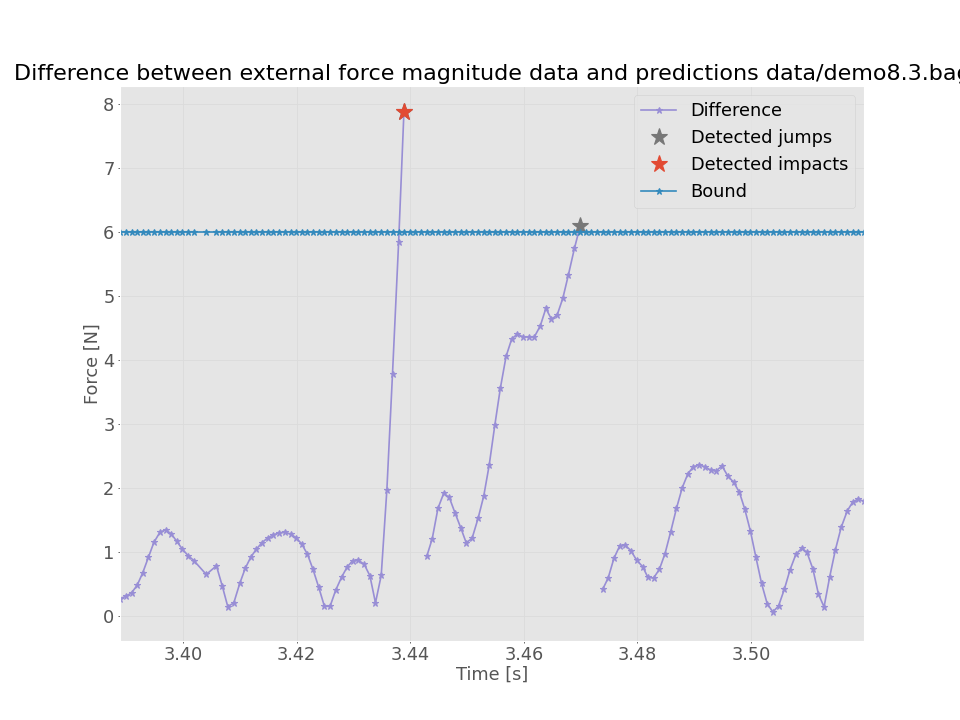

<IPython.core.display.Javascript object>


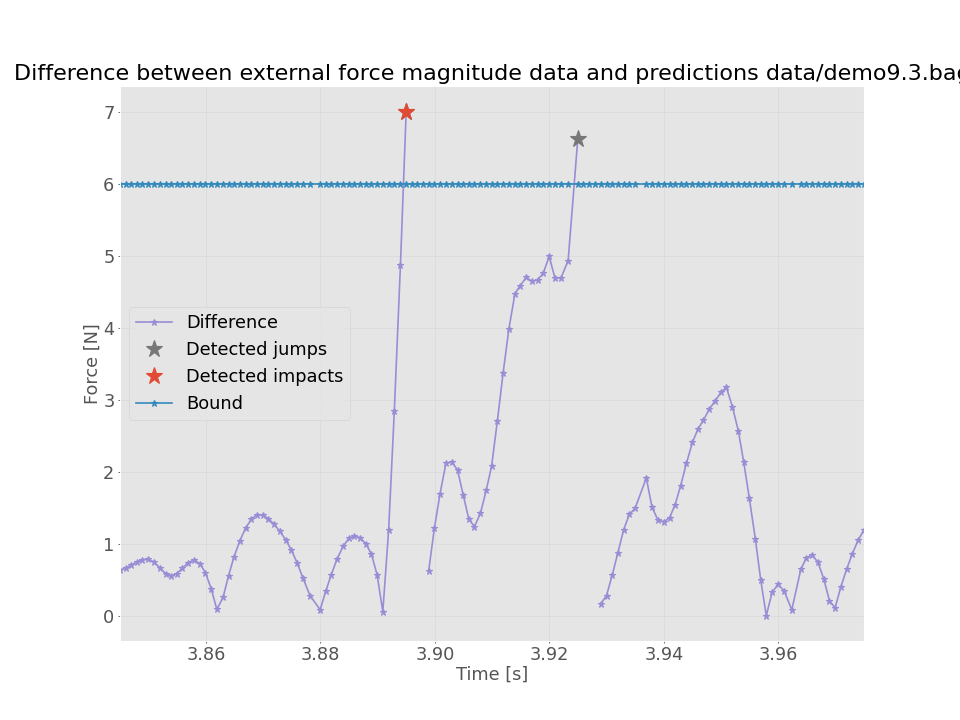

In [37]:
# Plot difference between data and prediction

for i in range(len(config.demos)):
    demo = config.demos[i]
    starting_index = starting_indices[i]
    ending_index = ending_indices[i]
    pred_diff = abs(force_ext[i][starting_index:ending_index] - predictions_data[i])
    
    fig = plt.figure(figsize=config.figsize, dpi=config.dpi)
    plt.rcParams['xtick.labelsize'] = config.fontsize2
    plt.rcParams['ytick.labelsize'] = config.fontsize2

    # Difference between data and prediction
    plt.plot(pred_diff.time, pred_diff.value, 'C2-*', linewidth=config.linewidth, markersize=config.markersize2, label='Difference')
    pred_diff_jumps = pred_diff[[index - starting_index for index in jump_indices_data[i]]]
    plt.plot(pred_diff_jumps.time, pred_diff_jumps.value, 'C3*', linewidth=config.linewidth, markersize=config.markersize1,label='Detected jumps')
    pred_diff_impacts = pred_diff[[index - starting_index for index in impact_indices_data[i]]]
    plt.plot(pred_diff_impacts.time, pred_diff_impacts.value, 'C0*', linewidth=config.linewidth, markersize=config.markersize1,label='Detected impacts')
    
    # Bound
    plt.plot(bounds_data[i].time, bounds_data[i].value, 'C1-*', linewidth=config.linewidth, markersize=config.markersize2, label='Bound')
    
    # Adding title and labels
    plt.title('Difference between external force magnitude data and predictions ' + demo,fontsize=config.fontsize1)
    plt.xlabel('Time [s]',fontsize=config.fontsize2)
    plt.ylabel('Force [N]',fontsize=config.fontsize2)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),fontsize=config.fontsize2)
    if config.xlim is not None and len(jump_indices_data[i]) > 0:
        x_min = force_ext[i][min(jump_indices_data[i])].time + config.xlim[0]
        x_max = force_ext[i][max(jump_indices_data[i])].time + config.xlim[-1]
        plt.xlim((x_min, x_max))

    title = fig.axes[0].get_title() + demo.split('/')[-1].split('\\')[-1]
    if config.save_figs:
        plt.savefig(config.save_figs_location + '/figures/' + title + '.png')

    if config.pickle_figs:
        pickle.dump(fig,open(config.save_figs_location + '/pickles/' + title + '.pickle','wb'))

    if not config.show_figs:
        plt.close()
        
if config.show_figs:
    plt.show()

<IPython.core.display.Javascript object>


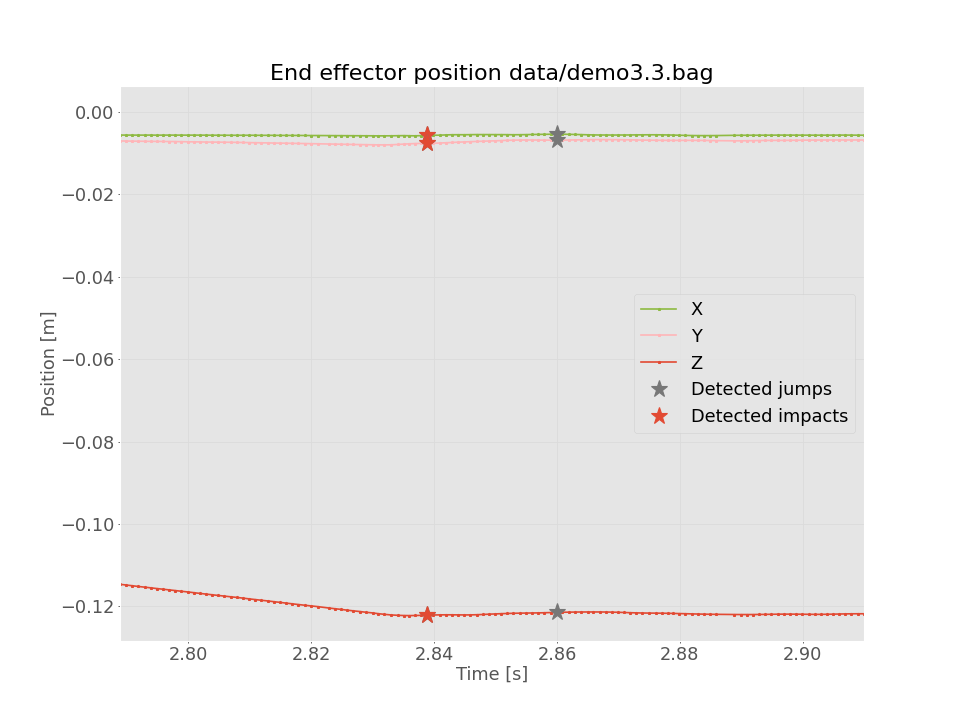

<IPython.core.display.Javascript object>


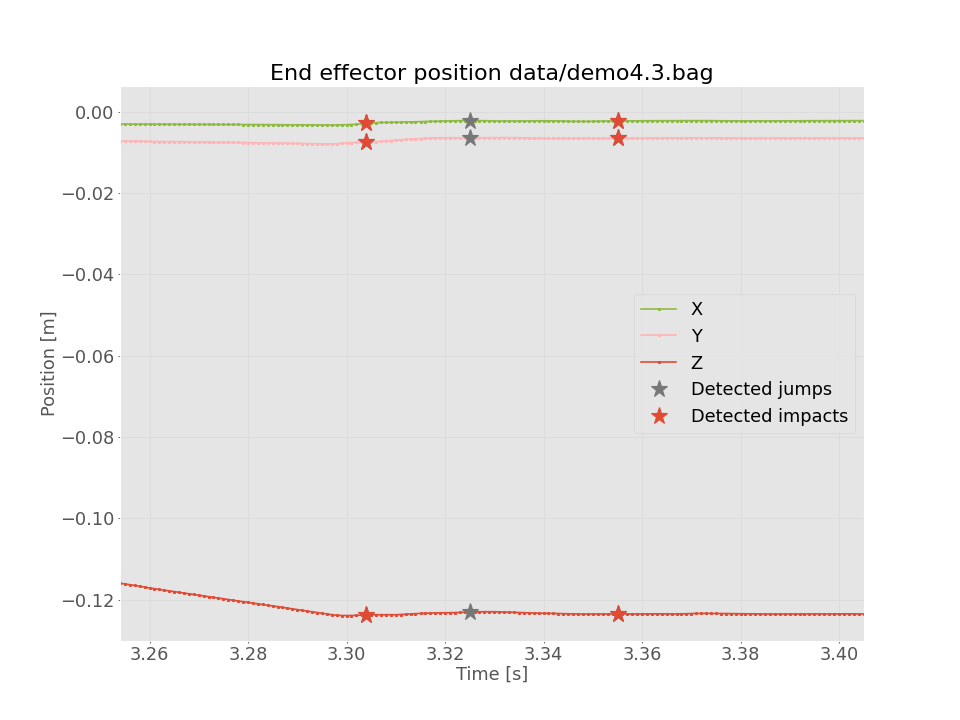

/home/sven/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


<IPython.core.display.Javascript object>


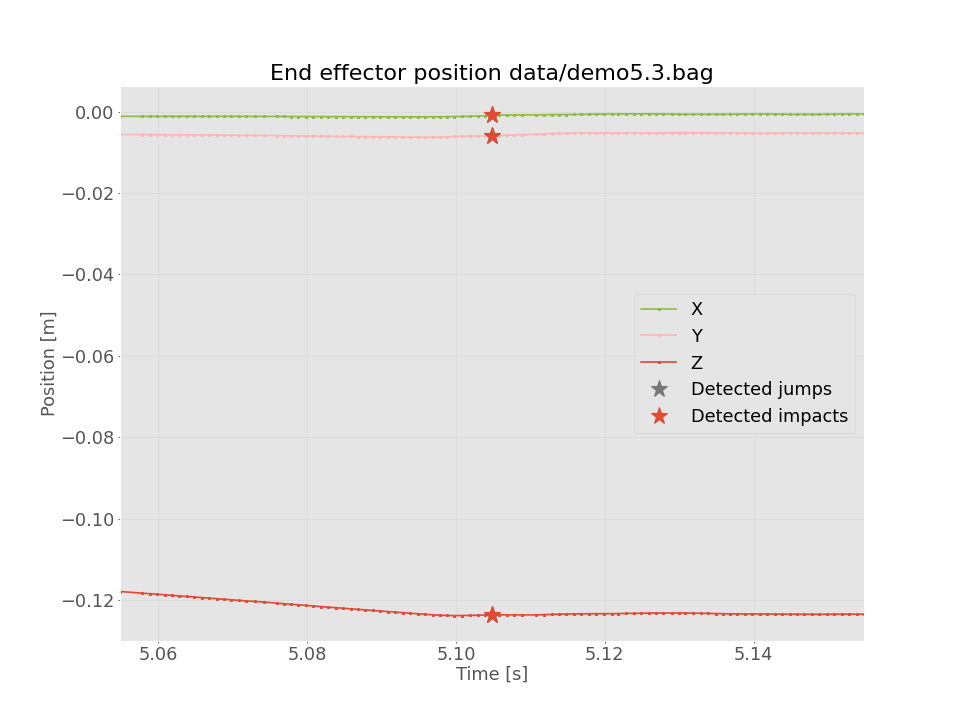

<IPython.core.display.Javascript object>


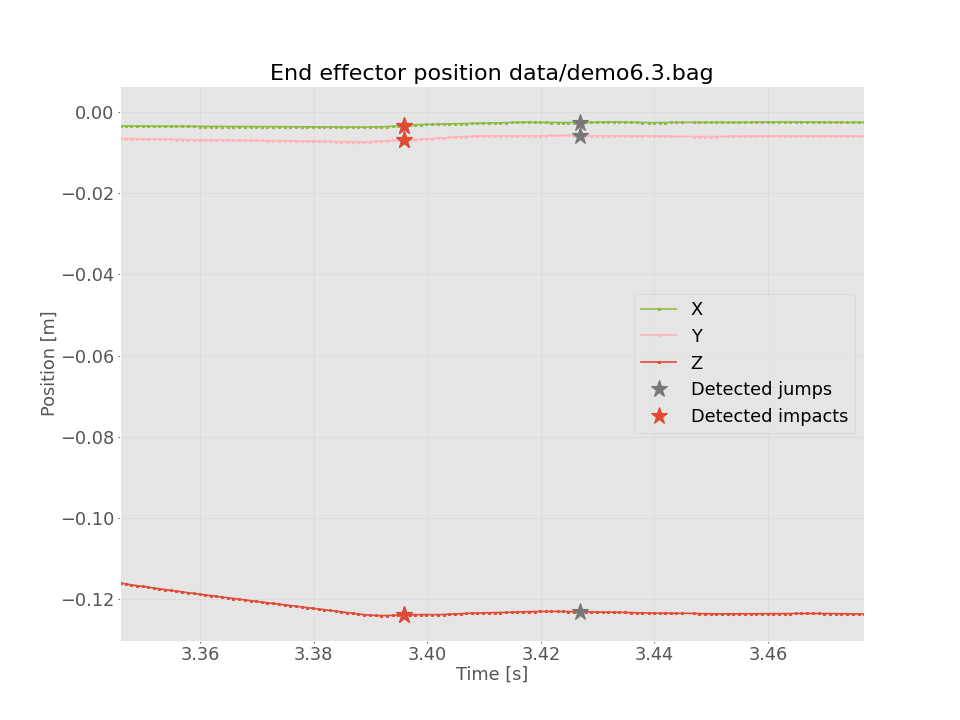

<IPython.core.display.Javascript object>


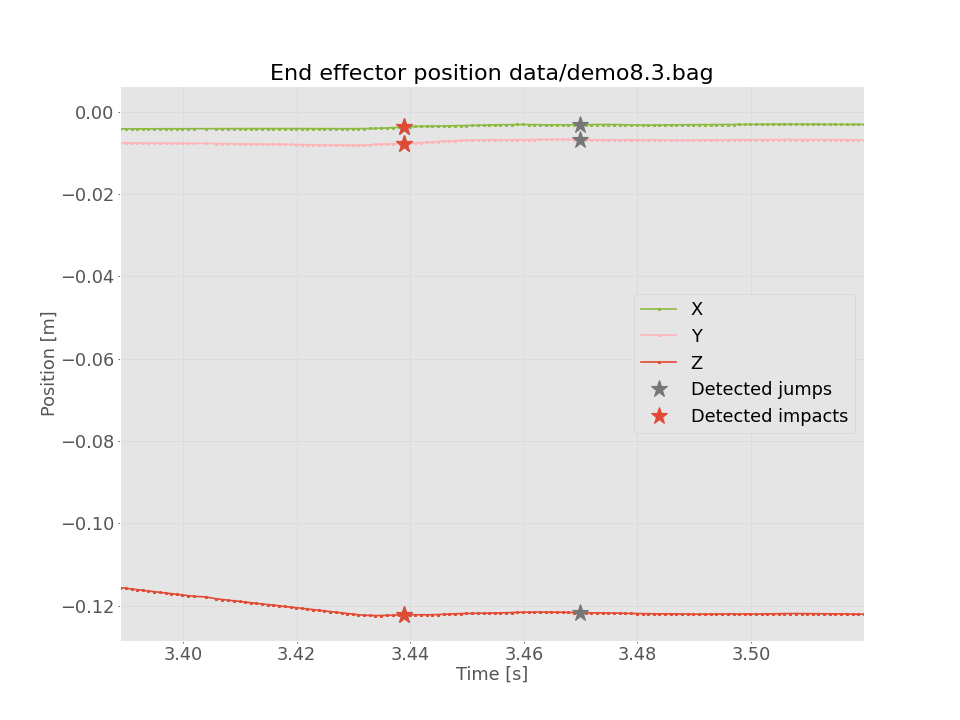

<IPython.core.display.Javascript object>


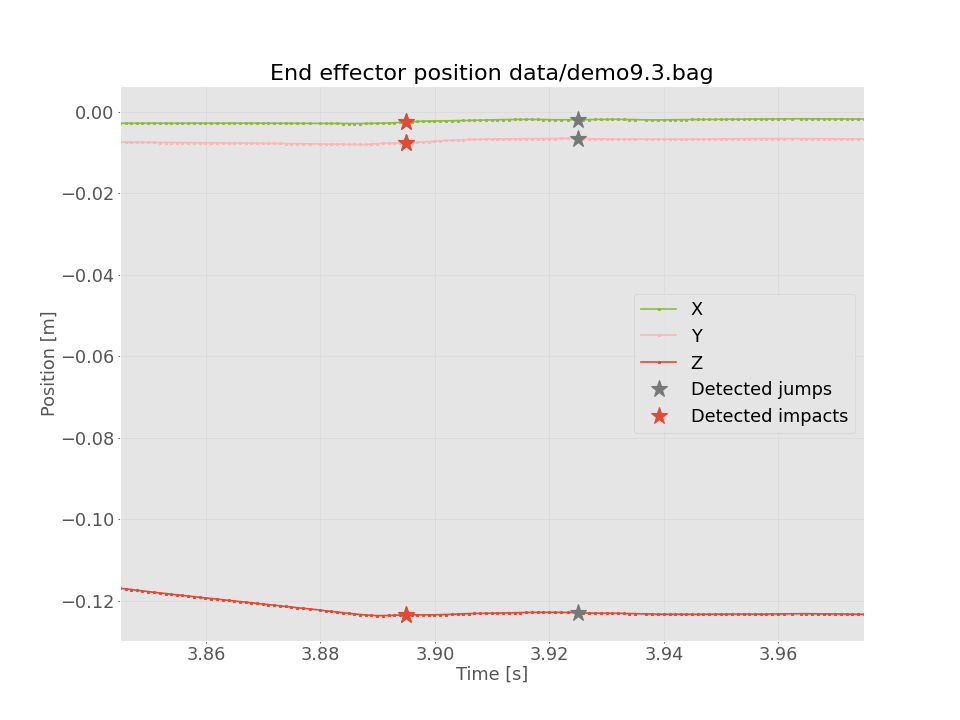

In [38]:
# Plot position data

for i in range(len(config.demos)):
    
    demo = config.demos[i]

    fig = plt.figure(figsize=config.figsize, dpi=config.dpi)
    plt.rcParams['xtick.labelsize'] = config.fontsize2
    plt.rcParams['ytick.labelsize'] = config.fontsize2

    # Position
    for j in range(3):
        plt.plot(position_data[i].time, (position_data[i].get_index(j)-position_data[i].get_index(j)[0]).value, 'C' + str(j+5) + '-*', linewidth=config.linewidth, markersize=config.markersize3, label=config.labels[j])
        
    for j in range(3):
        position_jumps = position_data[i].get_index(j)[jump_indices_data[i]]
        plt.plot(position_jumps.time, (position_jumps-position_data[i].get_index(j)[0]).value, 'C3*', linewidth=config.linewidth, markersize=config.markersize1, label='Detected jumps')
        position_impacts = position_data[i].get_index(j)[impact_indices_data[i]]
        plt.plot(position_impacts.time, (position_impacts-position_data[i].get_index(j)[0]).value, 'C0*', linewidth=config.linewidth, markersize=config.markersize1, label='Detected impacts')
        
    # Adding title and labels
    plt.title('End effector position ' + demo,fontsize=config.fontsize1)
    plt.xlabel('Time [s]',fontsize=config.fontsize2)
    plt.ylabel('Position [m]',fontsize=config.fontsize2)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),fontsize=config.fontsize2)
    if config.xlim is not None and len(jump_indices_data[i]) > 0:
        x_min = force_ext[i][min(jump_indices_data[i])].time + config.xlim[0]
        x_max = force_ext[i][max(jump_indices_data[i])].time + config.xlim[-1]
        plt.xlim((x_min, x_max))

    title = fig.axes[0].get_title() + demo.split('/')[-1].split('\\')[-1]
    if config.save_figs:
        plt.savefig(config.save_figs_location + '/figures/' + title + '.png')

    if config.pickle_figs:
        pickle.dump(fig,open(config.save_figs_location + '/pickles/' + title + '.pickle','wb'))

    if not config.show_figs:
        plt.close()
        
if config.show_figs:
    plt.show()

<IPython.core.display.Javascript object>


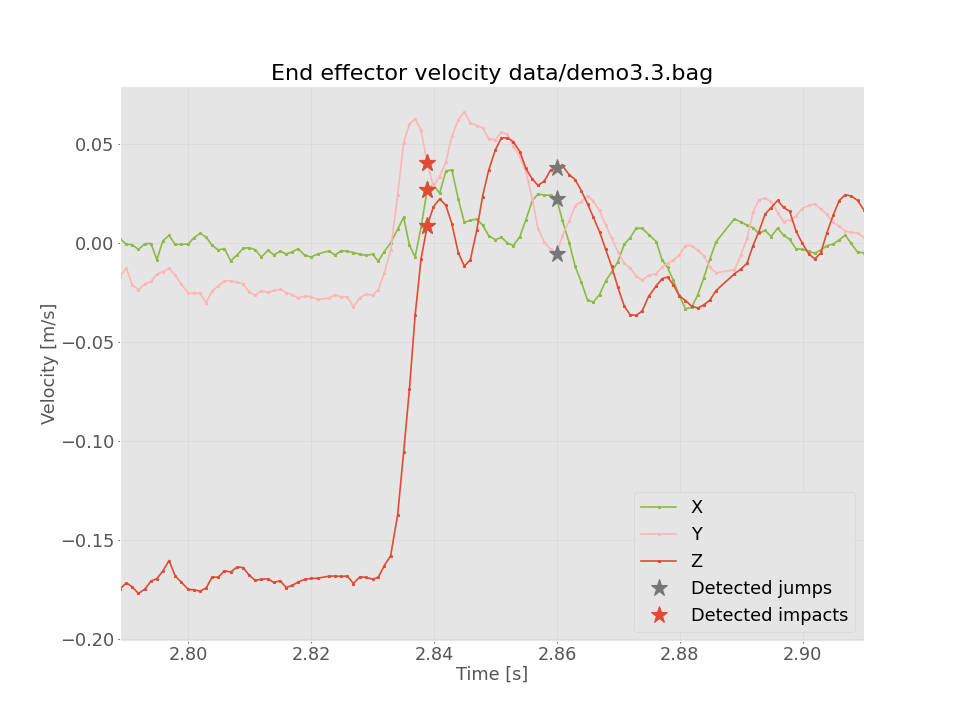

<IPython.core.display.Javascript object>


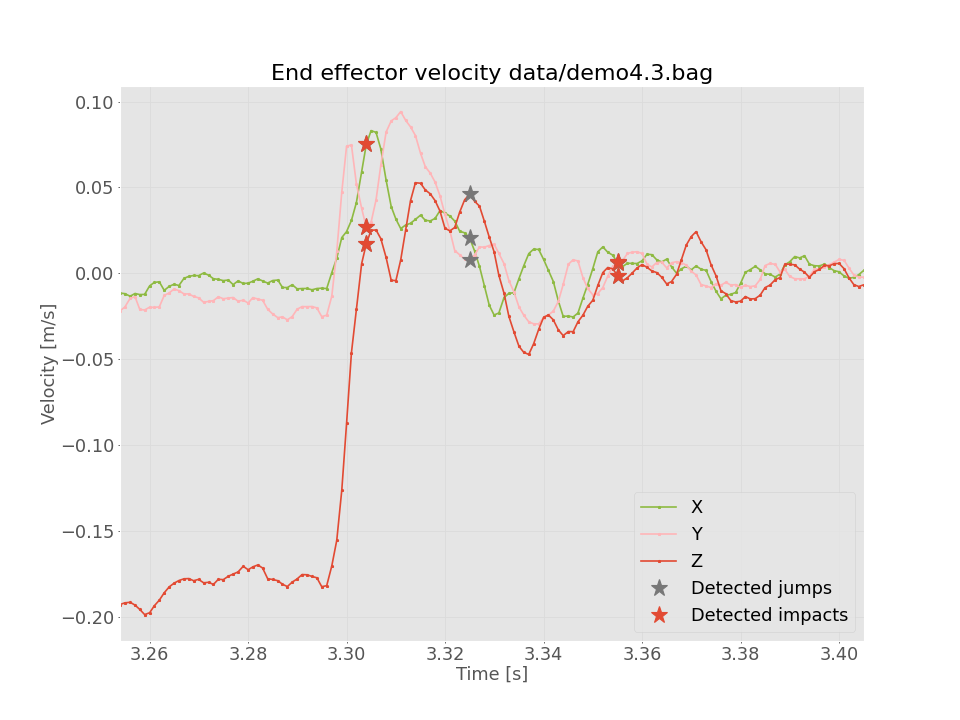

/home/sven/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


<IPython.core.display.Javascript object>


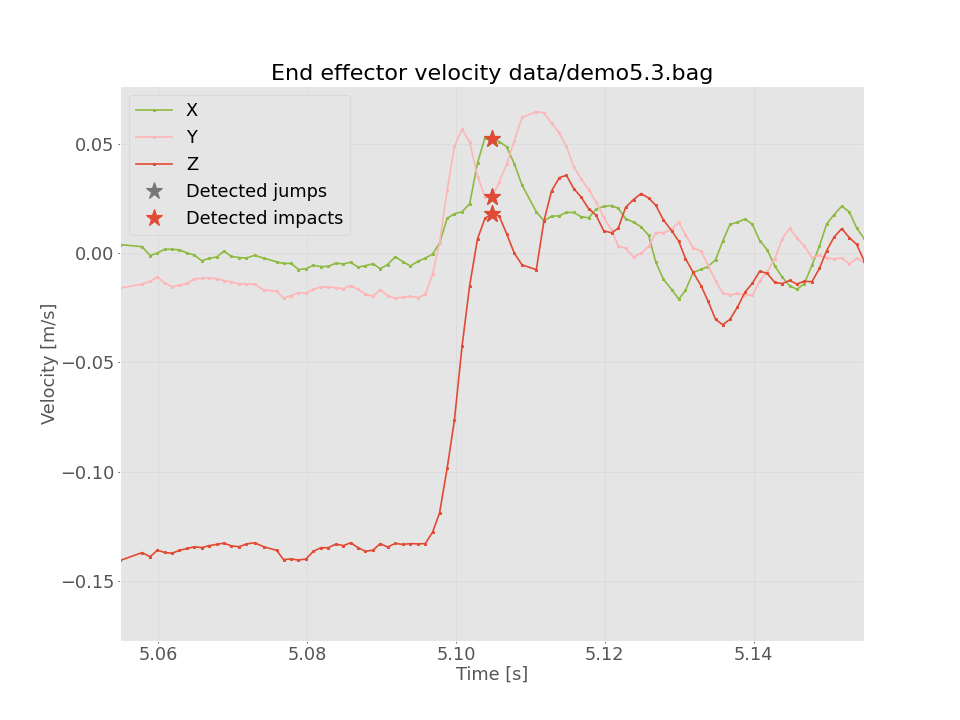

<IPython.core.display.Javascript object>


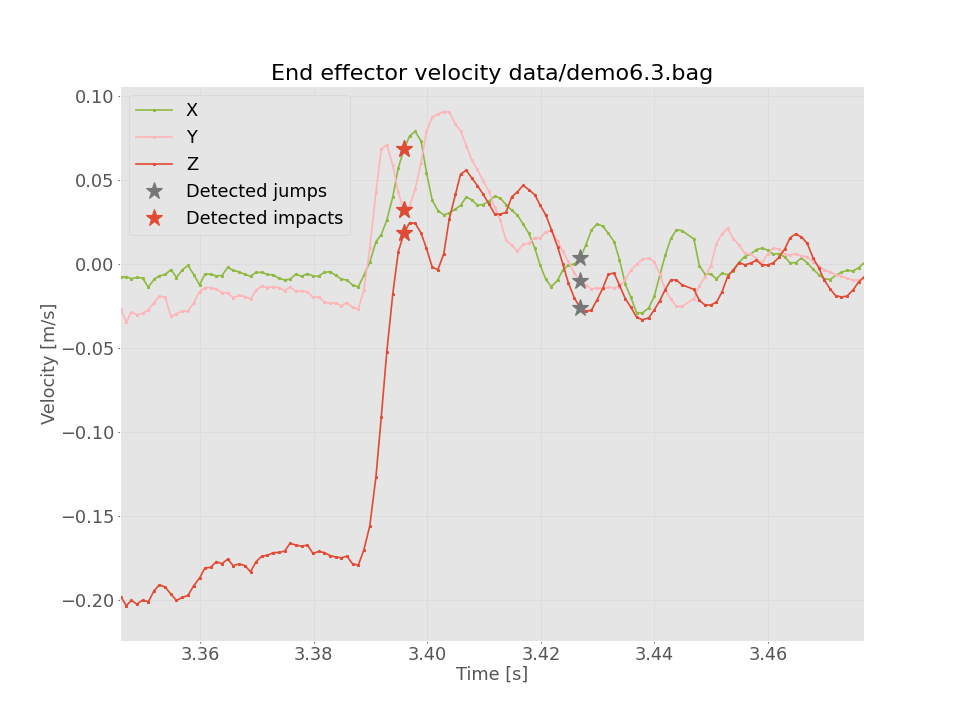

<IPython.core.display.Javascript object>


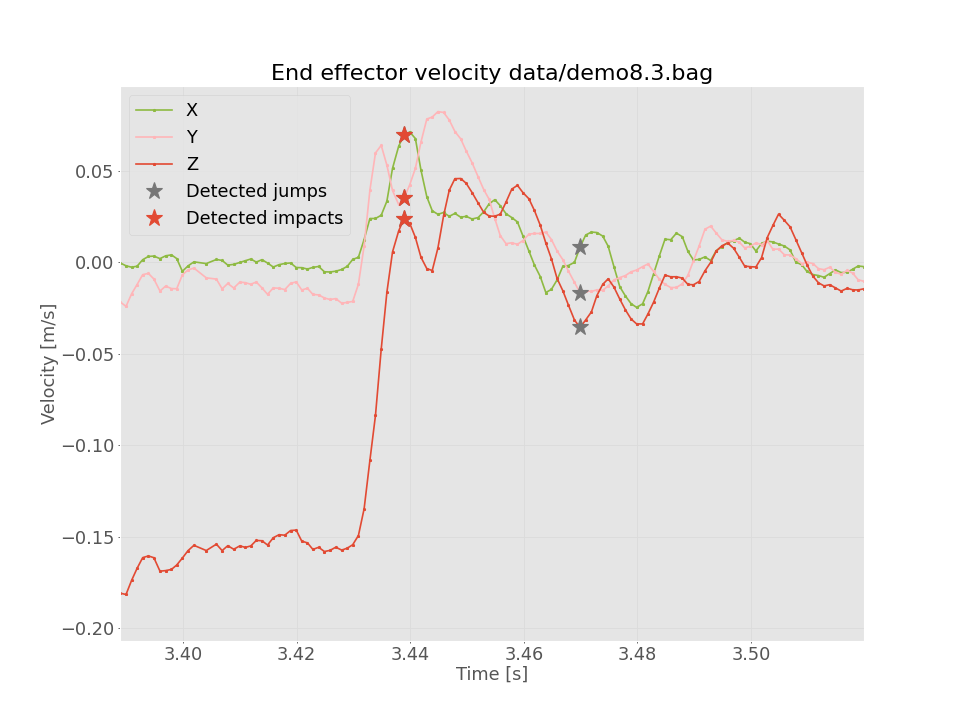

<IPython.core.display.Javascript object>


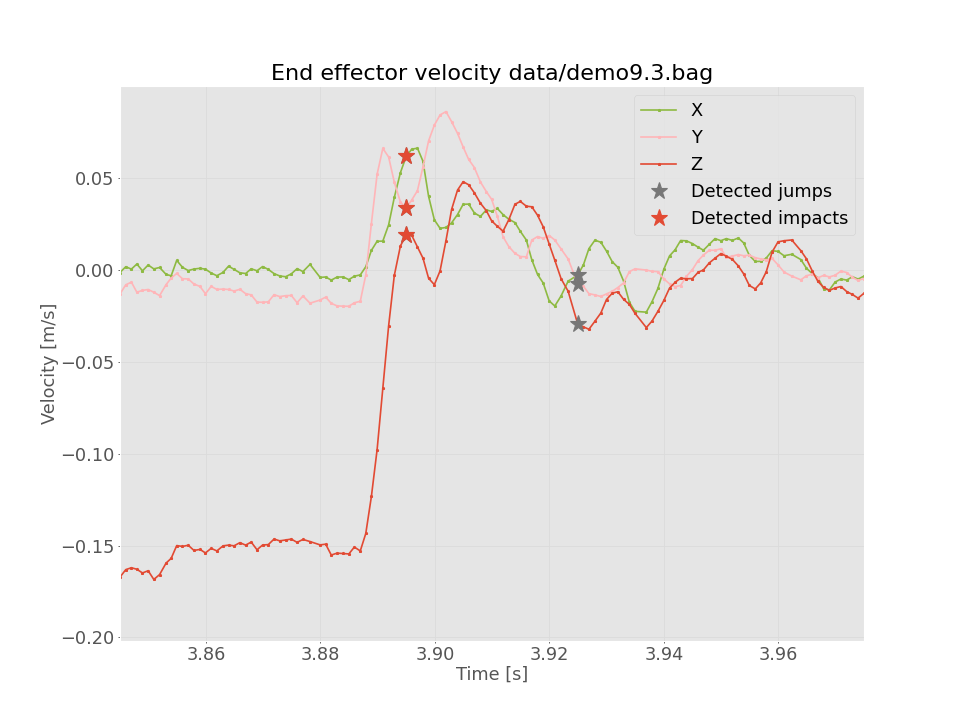

In [39]:
# Plot velocity data

for i in range(len(config.demos)):
    
    demo = config.demos[i]
    
    fig = plt.figure(figsize=config.figsize, dpi=config.dpi)
    plt.rcParams['xtick.labelsize'] = config.fontsize2
    plt.rcParams['ytick.labelsize'] = config.fontsize2
    
#     colors = [1, 2, 4]
#     for j in range(3):
#         euler_diff = position_data[i].get_index(j).diff()
#         plt.plot(euler_diff.time, euler_diff.value, 'C' + str(colors[j]) + '-*', linewidth=config.linewidth, markersize=config.markersize3, label=config.labels[j] + ' Euler differentiation')

    # Velocity
    for j in range(3):
        plt.plot(velocity_data[i].time, velocity_data[i].get_index(j).value, 'C' + str(j+5) + '-*', linewidth=config.linewidth, markersize=config.markersize3, label=config.labels[j])
        
    for j in range(3):
        velocity_jumps = velocity_data[i].get_index(j)[jump_indices_data[i]]
        plt.plot(velocity_jumps.time, velocity_jumps.value, 'C3*', linewidth=config.linewidth, markersize=config.markersize1, label='Detected jumps')
        velocity_impacts = velocity_data[i].get_index(j)[impact_indices_data[i]]
        plt.plot(velocity_impacts.time, velocity_impacts.value, 'C0*', linewidth=config.linewidth, markersize=config.markersize1, label='Detected impacts')
        
    # Adding title and labels
    plt.title('End effector velocity ' + demo,fontsize=config.fontsize1)
    plt.xlabel('Time [s]',fontsize=config.fontsize2)
    plt.ylabel('Velocity [m/s]',fontsize=config.fontsize2)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),fontsize=config.fontsize2)
    if config.xlim is not None and len(jump_indices_data[i]) > 0:
        x_min = force_ext[i][min(jump_indices_data[i])].time + config.xlim[0]
        x_max = force_ext[i][max(jump_indices_data[i])].time + config.xlim[-1]
        plt.xlim((x_min, x_max))

    title = fig.axes[0].get_title() + demo.split('/')[-1].split('\\')[-1]
    if config.save_figs:
        plt.savefig(config.save_figs_location + '/figures/' + title + '.png')

    if config.pickle_figs:
        pickle.dump(fig,open(config.save_figs_location + '/pickles/' + title + '.pickle','wb'))

    if not config.show_figs:
        plt.close()
        
if config.show_figs:
    plt.show()